In [29]:
# imports
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy 
import os

from pylab import *
from scipy import signal
from scipy import *
import numpy as np
from PIL import Image, ImageOps 

In [30]:
##############################################
### Provided code - nothing to change here ###
##############################################



"""
Harris Corner Detector
Usage: Call the function harris(filename) for corner detection
Reference   (Code adapted from):
             http://www.kaij.org/blog/?p=89
             Kai Jiang - Harris Corner Detector in Python
             
"""
# Usage: 
#harris('./path/to/image.jpg')


def harris(filename, min_distance = 10, threshold = 0.1):
    """
    filename: Path of image file
    threshold: (optional)Threshold for corner detection
    min_distance : (optional)Minimum number of pixels separating 
     corners and image boundary
     returns: filtered_coords list. index zero is row and index 1 is columns.
    """
    im = np.array(Image.open(filename).convert("L"))
    harrisim = compute_harris_response(im)
    filtered_coords = get_harris_points(harrisim,min_distance, threshold)
    plot_harris_points(im, filtered_coords)
    return filtered_coords

def gauss_derivative_kernels(size, sizey=None):
    """ returns x and y derivatives of a 2D 
        gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    y, x = mgrid[-size:size+1, -sizey:sizey+1]
    #x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    return gx,gy

def gauss_kernel(size, sizey = None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def compute_harris_response(im):
    """ compute the Harris corner detector response function 
        for each pixel in the image"""
    #derivatives
    gx,gy = gauss_derivative_kernels(3)
    imx = signal.convolve(im,gx, mode='same')
    imy = signal.convolve(im,gy, mode='same')
    #kernel for blurring
    gauss = gauss_kernel(3)
    #compute components of the structure tensor
    Wxx = signal.convolve(imx*imx,gauss, mode='same')
    Wxy = signal.convolve(imx*imy,gauss, mode='same')
    Wyy = signal.convolve(imy*imy,gauss, mode='same')   
    #determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy   
    return Wdet / Wtr

def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    """ return corners from a Harris response image
        min_distance is the minimum nbr of pixels separating 
        corners and image boundary"""
    #find top corner candidates above a threshold
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
    #sort candidates
    index = argsort(candidate_values)   
    #store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
    return filtered_coords

def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
    axis('off')
    show()

In [34]:
import numpy as np
import cv2
from scipy.spatial import distance

def extract_neighborhoods(image, keypoints, size=16):
    half_size = size // 2
    descriptors = []

    for (x, y) in keypoints:
        x, y = int(x), int(y)
        neighborhood = image[max(y - half_size, 0):y + half_size, max(x - half_size, 0):x + half_size]
        
        if neighborhood.shape == (size, size):  # Ensure the patch is of the required size
            descriptor = neighborhood.flatten()
            descriptors.append(descriptor)
    
    return np.array(descriptors)

def normalize_descriptors(descriptors):
    descriptors -= np.mean(descriptors, axis=1, keepdims=True)
    descriptors /= np.std(descriptors, axis=1, keepdims=True)
    return descriptors

def compute_distances(descriptors1, descriptors2, metric='euclidean'):
    if metric == 'euclidean':
        return distance.cdist(descriptors1, descriptors2, 'euclidean')
    elif metric == 'correlation':
        return distance.cdist(descriptors1, descriptors2, 'correlation')
    else:
        raise ValueError("Unsupported metric")

# Example usage
left_img = np.array(Image.open('Images/left.jpg').convert("L")).astype(float)
right_img = np.array(Image.open('Images/right.jpg').convert("L")).astype(float)
keypoints1 = [(50, 50), (100, 100)]  # Example keypoints
keypoints2 = [(60, 60), (120, 120)]  # Example keypoints

descriptors1 = extract_neighborhoods(left_img, keypoints1)
print("non-normalized")
print(descriptors1)
descriptors2 = extract_neighborhoods(right_img, keypoints2)
#print(descriptors2)

# Normalize descriptors
descriptors1 = normalize_descriptors(descriptors1)
print("normalized")
print(descriptors1)
descriptors2 = normalize_descriptors(descriptors2)
#print(descriptors2)

# Compute distances
distances = compute_distances(descriptors1, descriptors2, metric='euclidean')

print("Distances:\n", distances)


non-normalized
[[157. 157. 157. 157. 157. 157. 156. 156. 156. 156. 156. 156. 156. 156.
  157. 157. 156. 156. 156. 156. 156. 156. 156. 156. 156. 156. 156. 156.
  156. 156. 158. 158. 157. 157. 157. 157. 157. 157. 157. 157. 157. 157.
  157. 157. 157. 157. 158. 158. 157. 157. 157. 157. 157. 157. 157. 157.
  157. 157. 157. 157. 157. 157. 158. 158. 158. 158. 158. 158. 158. 158.
  157. 157. 157. 157. 157. 157. 157. 157. 158. 158. 159. 159. 159. 159.
  159. 159. 157. 157. 157. 157. 157. 157. 157. 157. 158. 158. 160. 160.
  160. 160. 160. 160. 159. 159. 159. 158. 158. 158. 158. 157. 160. 159.
  160. 160. 160. 160. 160. 160. 159. 159. 159. 158. 158. 158. 158. 158.
  160. 159. 160. 160. 160. 160. 160. 160. 159. 159. 159. 159. 159. 158.
  158. 158. 160. 160. 160. 160. 160. 160. 160. 160. 160. 160. 160. 159.
  159. 159. 159. 159. 160. 160. 160. 160. 160. 160. 160. 160. 160. 160.
  160. 160. 160. 159. 159. 159. 160. 160. 161. 161. 161. 161. 161. 161.
  161. 161. 161. 160. 160. 160. 160. 160. 161. 16

In [25]:

# Provided code for plotting inlier matches between two images

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
# Usage:
# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, img1, img2, computed_inliers)


In [26]:
# Function to globally normalize a 2D array to the range [0, 1] 
# def normalize(data):
#     return (data - data.min()) / (data.max() - data.min())

In [27]:
# # load each image 
# dir_path = "Images/"
# images = []     
# filenames = []
# for filename in os.listdir(dir_path):
#     if filename.endswith('.jpg'):
#         filenames.append(filename)
#         img_path = os.path.join(dir_path, filename)
#         img = Image.open(img_path)
#         #img.show()  # This will display the image
        
#         # convert images to grayscale
#         img_gs = ImageOps.grayscale(img) 
#         #img_gs.show()
#         img_gs = np.array(img_gs).astype(float)
#         img_gs = normalize(img_gs)
#         images.append(img_gs)

/tmp/ipykernel_6260/1620430642.py:75: RuntimeWarning: divide by zero encountered in divide
  return Wdet / Wtr


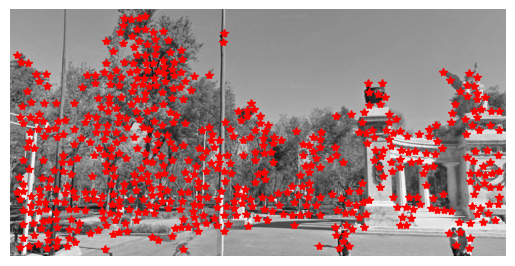

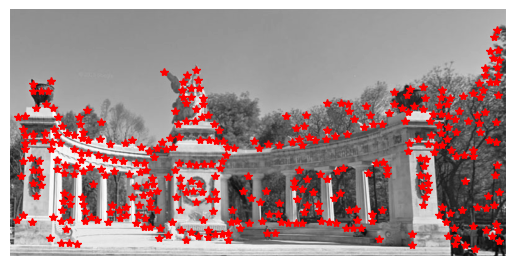

<class 'list'>
col 151, row 100
col 241, row 287
col 748, row 124
col 221, row 164
col 264, row 85
col 622, row 177
col 500, row 332
col 140, row 186
col 108, row 240
col 166, row 297
col 360, row 320
col 375, row 211
col 52, row 341
col 165, row 67
col 671, row 254
col 408, row 207
col 639, row 347
col 628, row 254
col 678, row 320
col 231, row 180
col 187, row 175
col 162, row 236
col 534, row 304
col 244, row 133
col 475, row 252
col 46, row 310
col 150, row 337
col 325, row 201
col 334, row 318
col 120, row 294
col 398, row 337
col 175, row 307
col 468, row 267
col 689, row 212
col 711, row 181
col 569, row 311
col 53, row 180
col 121, row 182
col 261, row 242
col 777, row 263
col 409, row 231
col 394, row 230
col 277, row 308
col 233, row 226
col 224, row 124
col 199, row 122
col 21, row 324
col 20, row 346
col 769, row 227
col 262, row 181
col 159, row 141
col 297, row 265
col 103, row 193
col 155, row 86
col 205, row 145
col 525, row 363
col 782, row 339
col 229, row 299
col 281

In [28]:

keypoints_left = harris('Images/left.jpg')
keypoints_right = harris('Images/right.jpg')
print(type(keypoints_left))
for kp in keypoints_left:
    print(f"col {kp[1]}, row {kp[0]}")